# Lymphoid_No3_proportions

## Import required modules

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sa
import statsmodels.formula.api as sfa
import scikit_posthocs as sp

In [2]:
sc.logging.print_header()
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=200, facecolor='white')

scanpy==1.7.1 anndata==0.7.5 umap==0.5.1 numpy==1.20.1 scipy==1.6.1 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.9.0 louvain==0.7.0 leidenalg==0.8.3


## Function

In [3]:
### commented out `ax=ax[celltypes_to_plot]` since all cells will be plotted and to avoid error

def plot_celltype_abundance(adata_obs, Region, variable='leiden_annotated', 
                            normalised_by=None, 
                            Genes_column='Gene',
                            Genes_to_plot=['PKP2', 'LMNA', 'PLN', 'RBM20', 'TTN', 'DES', 'control', 'mutation negative'], 
                            celltypes_to_plot=['CM', 'FB', 'MP', 'EC'], plottype="boxplot", 
                            show_points=True, return_table=False, save_png=None, ylimit=None):
    # Example how to use this function=
    # plot_celltype_abundance(adata_obs, 'AP', 'global_annotated'), where adata_obs=adata.obs
    
    count=0 # This is needed in case one genotype is not found
    
    # Subsetting for region
    if Region == "LV":
        tmp=adata_obs[adata_obs['Region'].isin(['FW', 'AP'])]
    
    elif Region == "LVS":
        tmp=adata_obs[adata_obs['Region'].isin(['FW', 'AP', 'S'])]
    
    elif Region == "all":
        tmp=adata_obs
    else:
        tmp=adata_obs[adata_obs['Region'].isin([Region])]
    
    # Calculates percentage per gene
    for gene_nr in range(len(Genes_to_plot)):
    #gene_nr=0
        Gene=Genes_to_plot[gene_nr]
        tmp_=tmp[tmp[Genes_column].isin([Gene])]
        ax= pd.crosstab(tmp_['Patient'], 
                        tmp_[variable]).apply(lambda r: r/r.sum()*100, axis=1).copy()
        if ax.shape[0]==0:
            continue
        if celltypes_to_plot is not None:
            # ax=ax[celltypes_to_plot]
            celltypes_to_plot=celltypes_to_plot[0:]
        if normalised_by is not None:
            normalize=ax[normalised_by]
            ax=ax.apply(lambda r: r/normalize, axis=0)
            y_axis_title="% celltype / "+ normalised_by
        else:
            y_axis_title="% celltype"
            
        index_ax = ax.index.to_frame(index=False) 
        ax = ax.reset_index(drop=True) 
        ax = pd.merge(index_ax, ax, left_index=True, right_index=True) 
        ax_melt=pd.melt(ax, id_vars='Patient')
        ax_melt[Genes_column]=Gene + " (n=" + str(ax.shape[0]) + ")"
        if ax.shape[0] != 0: 
            if count==0:
                final_df = ax_melt
                count=+1
            else:
                final_df=pd.concat([final_df, ax_melt], axis=0)
                
    # If you want to have a table only
    if return_table == True:
        return final_df
    
    # If you want to have a plot only
    else:
        %matplotlib inline
        plt.figure(figsize=[25,10], dpi=200, facecolor='w', edgecolor='k')
        if plottype == "boxplot":
            sns.set_style(style='white')
            flierprops = dict(markerfacecolor='0.75', markersize=3,
                          linestyle='none')
            if show_points is True:
                ax=sns.swarmplot(x="variable", y="value", hue=Genes_column, data=final_df, color=".25", dodge=True, size=3)
            ax=sns.boxplot(x="variable", y='value', hue=Genes_column, data=final_df, flierprops=flierprops, showfliers = False)
            handles, labels = ax.get_legend_handles_labels()
            plt.legend(handles[0:len(set(final_df[Genes_column]))], 
                       labels[0:len(set(final_df[Genes_column]))], 
                       bbox_to_anchor=(1.05, 1), loc='lower center', 
                       borderaxespad=0., ncol=6, fontsize='x-large')
            
            spines = 2
            ax.spines["top"].set_linewidth(spines)
            ax.spines["left"].set_linewidth(spines)
            ax.spines["bottom"].set_linewidth(spines)
            ax.spines["right"].set_linewidth(spines)
            
            ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
            ax.set_ylabel(y_axis_title,fontsize=30)
            ax.set_xlabel("",fontsize=30)
            ax.tick_params(axis='x', labelsize=30)
            ax.tick_params(axis='y', labelsize=20)
            if ylimit is not None:
                ax.set(ylim=(0, ylimit))
        
        elif plottype == "violinplot":           
            if show_points == True:
                ax = sns.violinplot(x="variable", y="value", hue=Genes_column, data=final_df, inner="points")
            else:
                ax = sns.violinplot(x="variable", y="value", hue=Genes_column, data=final_df) 
            handles, labels = ax.get_legend_handles_labels()
            ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
            plt.legend(handles[0:len(set(final_df[Genes_column]))], labels[0:len(set(final_df[Genes_column]))], bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=0., fontsize='x-large')
            ax.set_ylabel(y_axis_title,fontsize=40)
            ax.set_xlabel("Cell type",fontsize=40)
            ax.tick_params(labelsize=30)
            ax
    
    # If you want to save the figure
    if save_png != None:
        plt.savefig(save_png, transparent=True)

## Read annotated lymphoid data and remove replicates

In [4]:
adata = sc.read_h5ad('/nfs/team205/kk18/DCM/anndata/Lymphoid_annotated_scVI-UMAP_210513.h5ad')

# remove replicates
adata = adata[adata.obs['Sample'].isin(['BO_H08_LV0_premrna','BO_H12_RV0_premrna','BO_H40_LV1_premrna','BO_H40_LVW_premrna','BO_H49_LV1_premrna','BO_H51_LV1_premrna'])==False]

# remove unclassified cells
adata = adata[adata.obs['cell_states'].isin(['unclassified.1','unclassified.2'])==False]

# replace 'mutation negative' with 'PVneg'
adata.obs.replace({'Gene':{'mutation negative':'PVneg'}}, inplace=True)
adata

adata

/home/jovyan/my-conda-envs/kk14-env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/kk14-env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


View of AnnData object with n_obs × n_vars = 16454 × 25134
    obs: 'Sample', 'Patient', 'Gender', 'Region', 'Diagnosis', 'Gene', 'Clinical.dominant.mutation', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'scrublet_score_z', 'scrublet_score_log', 'solo_score', 'cell_type', 'cell_states'
    var: 'gene_ids-DCM', 'feature_types-DCM', 'genome-DCM', 'gene_ids-Harvard-Nuclei-HCA', 'feature_types-Harvard-Nuclei-HCA', 'gene_ids-Sanger-Nuclei-HCA', 'feature_types-Sanger-Nuclei-HCA', 'gene_ids-Sanger-Cells-HCA', 'feature_types-Sanger-Cells-HCA', 'gene_ids-Sanger-CD45-HCA', 'feature_types-Sanger-CD45-HCA', 'n_counts'
    uns: 'Cells_Nuclei_colors', '_scvi', 'cell_states_20210305_colors', 'hvg', 'leiden', 'leiden_scVI_colors', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

## Lymphocytes proportion to all lymphocytes per genotype

### LVS

In [5]:
# plot_celltype_abundance, returning table
LVS_df = plot_celltype_abundance(adata_obs=adata.obs, 
                        Region='LVS', 
                        variable='cell_states',
                        normalised_by=None,
                        Genes_column='Gene',
                        Genes_to_plot=['control','LMNA','TTN','RBM20','PKP2','PVneg'],
                        celltypes_to_plot=adata.obs['cell_states'].cat.categories, plottype="boxplot",
                        show_points=True, return_table=True, save_png=None, ylimit=None)

LVS_df['variable']=LVS_df['variable'].astype('category')
LVS_df['variable'].cat.reorder_categories(adata.obs['cell_states'].cat.categories, inplace=True)
LVS_df['variable'].cat.categories

Index(['B', 'Plasma', 'CD4T_naive', 'CD4T_act', 'CD4T_reg', 'CD8T_cytox',
       'CD8T_trans', 'CD8T_te', 'CD8T_te_IFNGhi', 'CD8T_em', 'MAIT-like',
       'NK_CD16hi', 'NK_CD16hiIFNGhi', 'NK_CD56hi', 'ILC', 'prolif_Lymphoids'],
      dtype='object')

/home/jovyan/my-conda-envs/kk14-env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 11.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jovyan/my-conda-envs/kk14-env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jovyan/my-conda-envs/kk14-env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jovyan/my-conda-envs/kk14-env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 22.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jovyan/my-cond

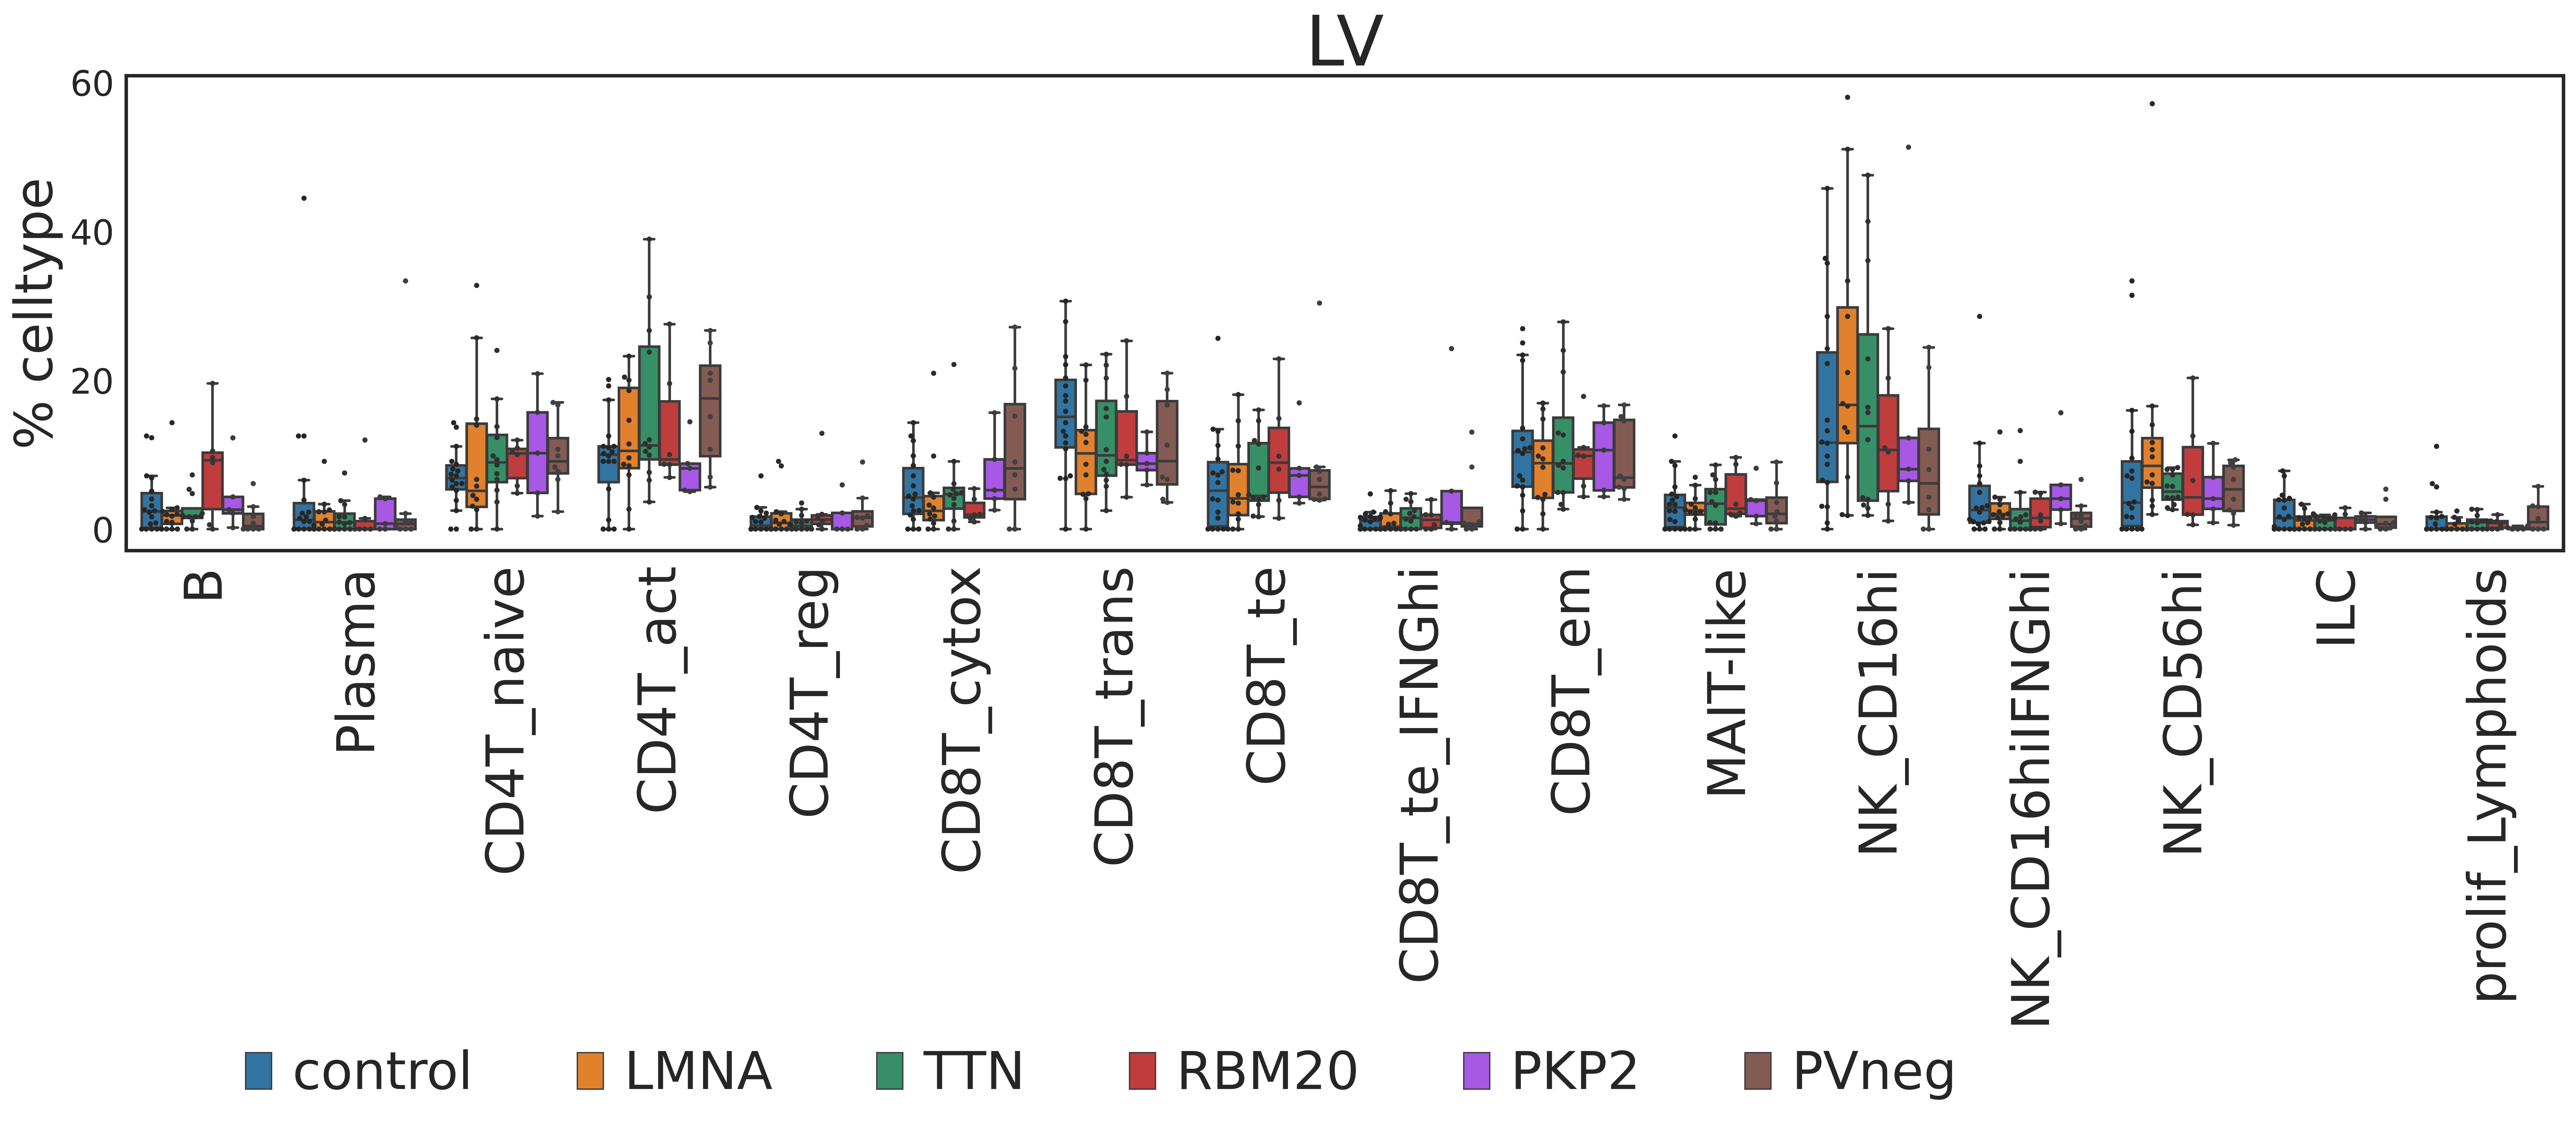

In [6]:
# plotting
# codes were extracted from plot_celltype_abundance to modify legend position, etc
final_df=LVS_df.copy()

Genes_column='Gene'
y_axis_title="% celltype"

plt.figure(figsize=[25,5], dpi=500, facecolor='w', edgecolor='k')
       
sns.set_style(style='white')
flierprops = dict(markerfacecolor='0.75', markersize=3,linestyle='none')
ax=sns.swarmplot(x="variable", y="value", hue=Genes_column, data=final_df, color=".25", dodge=True, size=3)
ax=sns.boxplot(x="variable", y='value', hue=Genes_column, data=final_df, flierprops=flierprops, showfliers = False)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:len(set(final_df[Genes_column]))],
           [x.split(' ')[0] for x in labels[0:len(set(final_df[Genes_column]))]],
           bbox_to_anchor=(0.4, -1.2), loc='lower center',
           borderaxespad=0., ncol=6, fontsize='30',
          frameon=False)
            
spines = 2
ax.spines["top"].set_linewidth(spines)
ax.spines["left"].set_linewidth(spines)
ax.spines["bottom"].set_linewidth(spines)
ax.spines["right"].set_linewidth(spines)
            
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel(y_axis_title,fontsize=30)
ax.set_xlabel("",fontsize=30)
ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=20)
ax.set_title('LV', fontsize=40)

plt.savefig('/home/jovyan/projects/kk14_DCM-lymphoid/notebooks/final/figures/SupFig16B_abundance_LVS.png', transparent=True, bbox_inches="tight")
plt.show()

### LVS, statistical test

In [7]:
# statistical test, vs control
for cell in LVS_df['variable'].cat.categories:
    df=LVS_df[LVS_df['variable']==cell]
    res=sp.posthoc_ttest(df, val_col='value', group_col='Gene', equal_var=False, p_adjust='holm')
    res_df = pd.DataFrame({
        'Gene':res['control (n=18)'].index,
        'variable':cell,
        'pval_vs_control':res['control (n=18)'].values
    })
    if cell==LVS_df['variable'].cat.categories[0]:
        res_concat=res_df
    else:
        res_concat=pd.concat([res_concat,res_df],axis=0)
    del df, res, res_df

# adjusting p-value with the number of celltypes
res_concat['padj_vs_control']=np.clip(res_concat['pval_vs_control']*len(LVS_df['variable'].cat.categories),0,1)

res_concat

Gene          variable  pval_vs_control  padj_vs_control
0   control (n=18)                 B         1.000000              1.0
1      LMNA (n=12)                 B         1.000000              1.0
2       TTN (n=12)                 B         1.000000              1.0
3      RBM20 (n=6)                 B         1.000000              1.0
4       PKP2 (n=5)                 B         1.000000              1.0
..             ...               ...              ...              ...
1      LMNA (n=12)  prolif_Lymphoids         1.000000              1.0
2       TTN (n=12)  prolif_Lymphoids         1.000000              1.0
3      RBM20 (n=6)  prolif_Lymphoids         1.000000              1.0
4       PKP2 (n=5)  prolif_Lymphoids         0.572783              1.0
5      PVneg (n=8)  prolif_Lymphoids         1.000000              1.0

[96 rows x 4 columns]

In [8]:
res_concat[res_concat['pval_vs_control']<0.05]

Empty DataFrame
Columns: [Gene, variable, pval_vs_control, padj_vs_control]
Index: []

**-> No significant difference compared with control**

### RV

In [9]:
RV_df = plot_celltype_abundance(adata_obs=adata.obs, 
                        Region='RV', 
                        variable='cell_states',
                        normalised_by=None,
                        Genes_column='Gene',
                        Genes_to_plot=['control','LMNA','TTN','RBM20','PKP2','PVneg'],
                        celltypes_to_plot=adata.obs['cell_states'].cat.categories, plottype="boxplot",
                        show_points=True, return_table=True, save_png=None, ylimit=None)

RV_df['variable']=RV_df['variable'].astype('category')
RV_df['variable'].cat.reorder_categories(adata.obs['cell_states'].cat.categories, inplace=True)
RV_df['variable'].cat.categories

Index(['B', 'Plasma', 'CD4T_naive', 'CD4T_act', 'CD4T_reg', 'CD8T_cytox',
       'CD8T_trans', 'CD8T_te', 'CD8T_te_IFNGhi', 'CD8T_em', 'MAIT-like',
       'NK_CD16hi', 'NK_CD16hiIFNGhi', 'NK_CD56hi', 'ILC', 'prolif_Lymphoids'],
      dtype='object')

/home/jovyan/my-conda-envs/kk14-env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 42.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jovyan/my-conda-envs/kk14-env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 21.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jovyan/my-conda-envs/kk14-env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 14.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jovyan/my-conda-envs/kk14-env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 57.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jovyan/my-cond

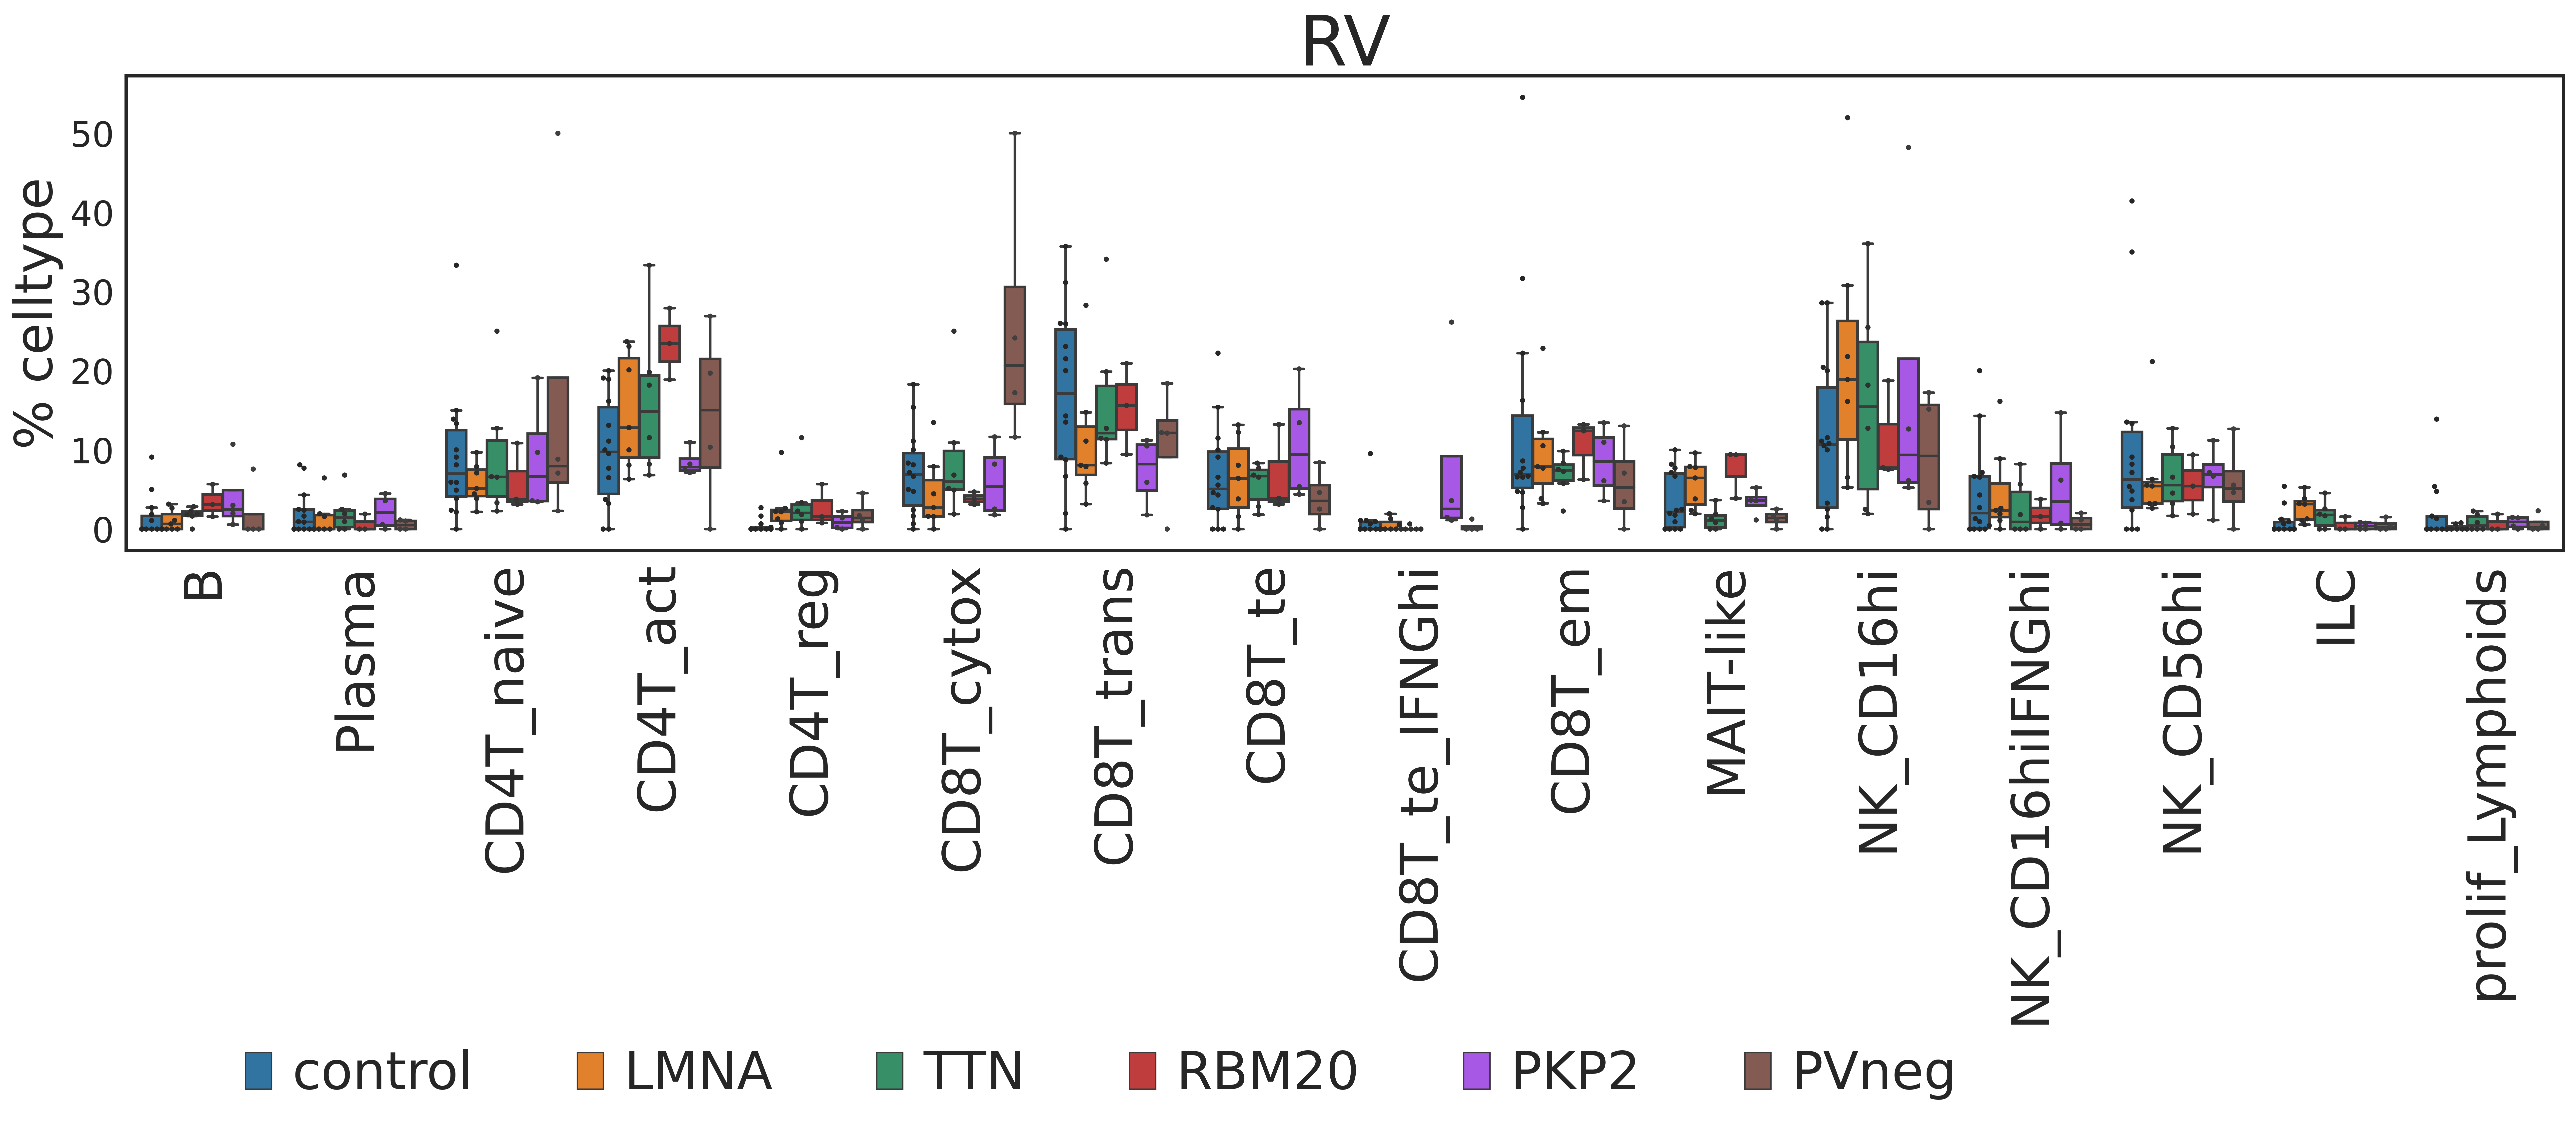

In [10]:
# plotting
# codes were extracted from plot_celltype_abundance to modify legend position, etc
final_df=RV_df.copy()

Genes_column='Gene'
y_axis_title="% celltype"

plt.figure(figsize=[25,5], dpi=500, facecolor='w', edgecolor='k')
       
sns.set_style(style='white')
flierprops = dict(markerfacecolor='0.75', markersize=3,linestyle='none')
ax=sns.swarmplot(x="variable", y="value", hue=Genes_column, data=final_df, color=".25", dodge=True, size=3)
ax=sns.boxplot(x="variable", y='value', hue=Genes_column, data=final_df, flierprops=flierprops, showfliers = False)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:len(set(final_df[Genes_column]))],
           [x.split(' ')[0] for x in labels[0:len(set(final_df[Genes_column]))]],
           bbox_to_anchor=(0.4, -1.2), loc='lower center',
           borderaxespad=0., ncol=6, fontsize='30',
          frameon=False)
            
spines = 2
ax.spines["top"].set_linewidth(spines)
ax.spines["left"].set_linewidth(spines)
ax.spines["bottom"].set_linewidth(spines)
ax.spines["right"].set_linewidth(spines)
            
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel(y_axis_title,fontsize=30)
ax.set_xlabel("",fontsize=30)
ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=20)
ax.set_title('RV', fontsize=40)

plt.savefig('/home/jovyan/projects/kk14_DCM-lymphoid/notebooks/final/figures/SupFig16B_abundance_RV.png', transparent=True, bbox_inches="tight")
plt.show()

### RV, statistical test

In [11]:
# statistical test, vs control
for cell in RV_df['variable'].cat.categories:
    df=RV_df[RV_df['variable']==cell]
    res=sp.posthoc_ttest(df, val_col='value', group_col='Gene', equal_var=False, p_adjust='holm')
    res_df = pd.DataFrame({
        'Gene':res['control (n=14)'].index,
        'variable':cell,
        'pval_vs_control':res['control (n=14)'].values
    })
    if cell==RV_df['variable'].cat.categories[0]:
        res_concat=res_df
    else:
        res_concat=pd.concat([res_concat,res_df],axis=0)
    del df, res, res_df

# adjusting p-value with the number of celltypes
res_concat['padj_vs_control']=np.clip(res_concat['pval_vs_control']*len(RV_df['variable'].cat.categories),0,1)

res_concat

Gene          variable  pval_vs_control  padj_vs_control
0   control (n=14)                 B              1.0              1.0
1       LMNA (n=7)                 B              1.0              1.0
2        TTN (n=6)                 B              1.0              1.0
3      RBM20 (n=3)                 B              1.0              1.0
4       PKP2 (n=4)                 B              1.0              1.0
..             ...               ...              ...              ...
1       LMNA (n=7)  prolif_Lymphoids              1.0              1.0
2        TTN (n=6)  prolif_Lymphoids              1.0              1.0
3      RBM20 (n=3)  prolif_Lymphoids              1.0              1.0
4       PKP2 (n=4)  prolif_Lymphoids              1.0              1.0
5      PVneg (n=4)  prolif_Lymphoids              1.0              1.0

[95 rows x 4 columns]

In [12]:
res_concat[res_concat['pval_vs_control']<0.05]

Empty DataFrame
Columns: [Gene, variable, pval_vs_control, padj_vs_control]
Index: []

**-> No significant difference compared with control**

## Lymphocytes proportion to all lymphocytes per region

In [13]:
df = plot_celltype_abundance(adata_obs=adata.obs, 
                        Region='all', 
                        variable='cell_states',
                        normalised_by=None,
                        Genes_column='Region',
                        Genes_to_plot=['RV','FW','AP','S'],
                        celltypes_to_plot=adata.obs['cell_states'].cat.categories, plottype="boxplot",
                        show_points=True, return_table=True, save_png=None, ylimit=None)

df['variable']=df['variable'].astype('category')
df['variable'].cat.reorder_categories(adata.obs['cell_states'].cat.categories, inplace=True)
df['variable'].cat.categories

Index(['B', 'Plasma', 'CD4T_naive', 'CD4T_act', 'CD4T_reg', 'CD8T_cytox',
       'CD8T_trans', 'CD8T_te', 'CD8T_te_IFNGhi', 'CD8T_em', 'MAIT-like',
       'NK_CD16hi', 'NK_CD16hiIFNGhi', 'NK_CD56hi', 'ILC', 'prolif_Lymphoids'],
      dtype='object')

/home/jovyan/my-conda-envs/kk14-env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 52.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jovyan/my-conda-envs/kk14-env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 48.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jovyan/my-conda-envs/kk14-env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 28.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jovyan/my-conda-envs/kk14-env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 46.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jovyan/my-cond

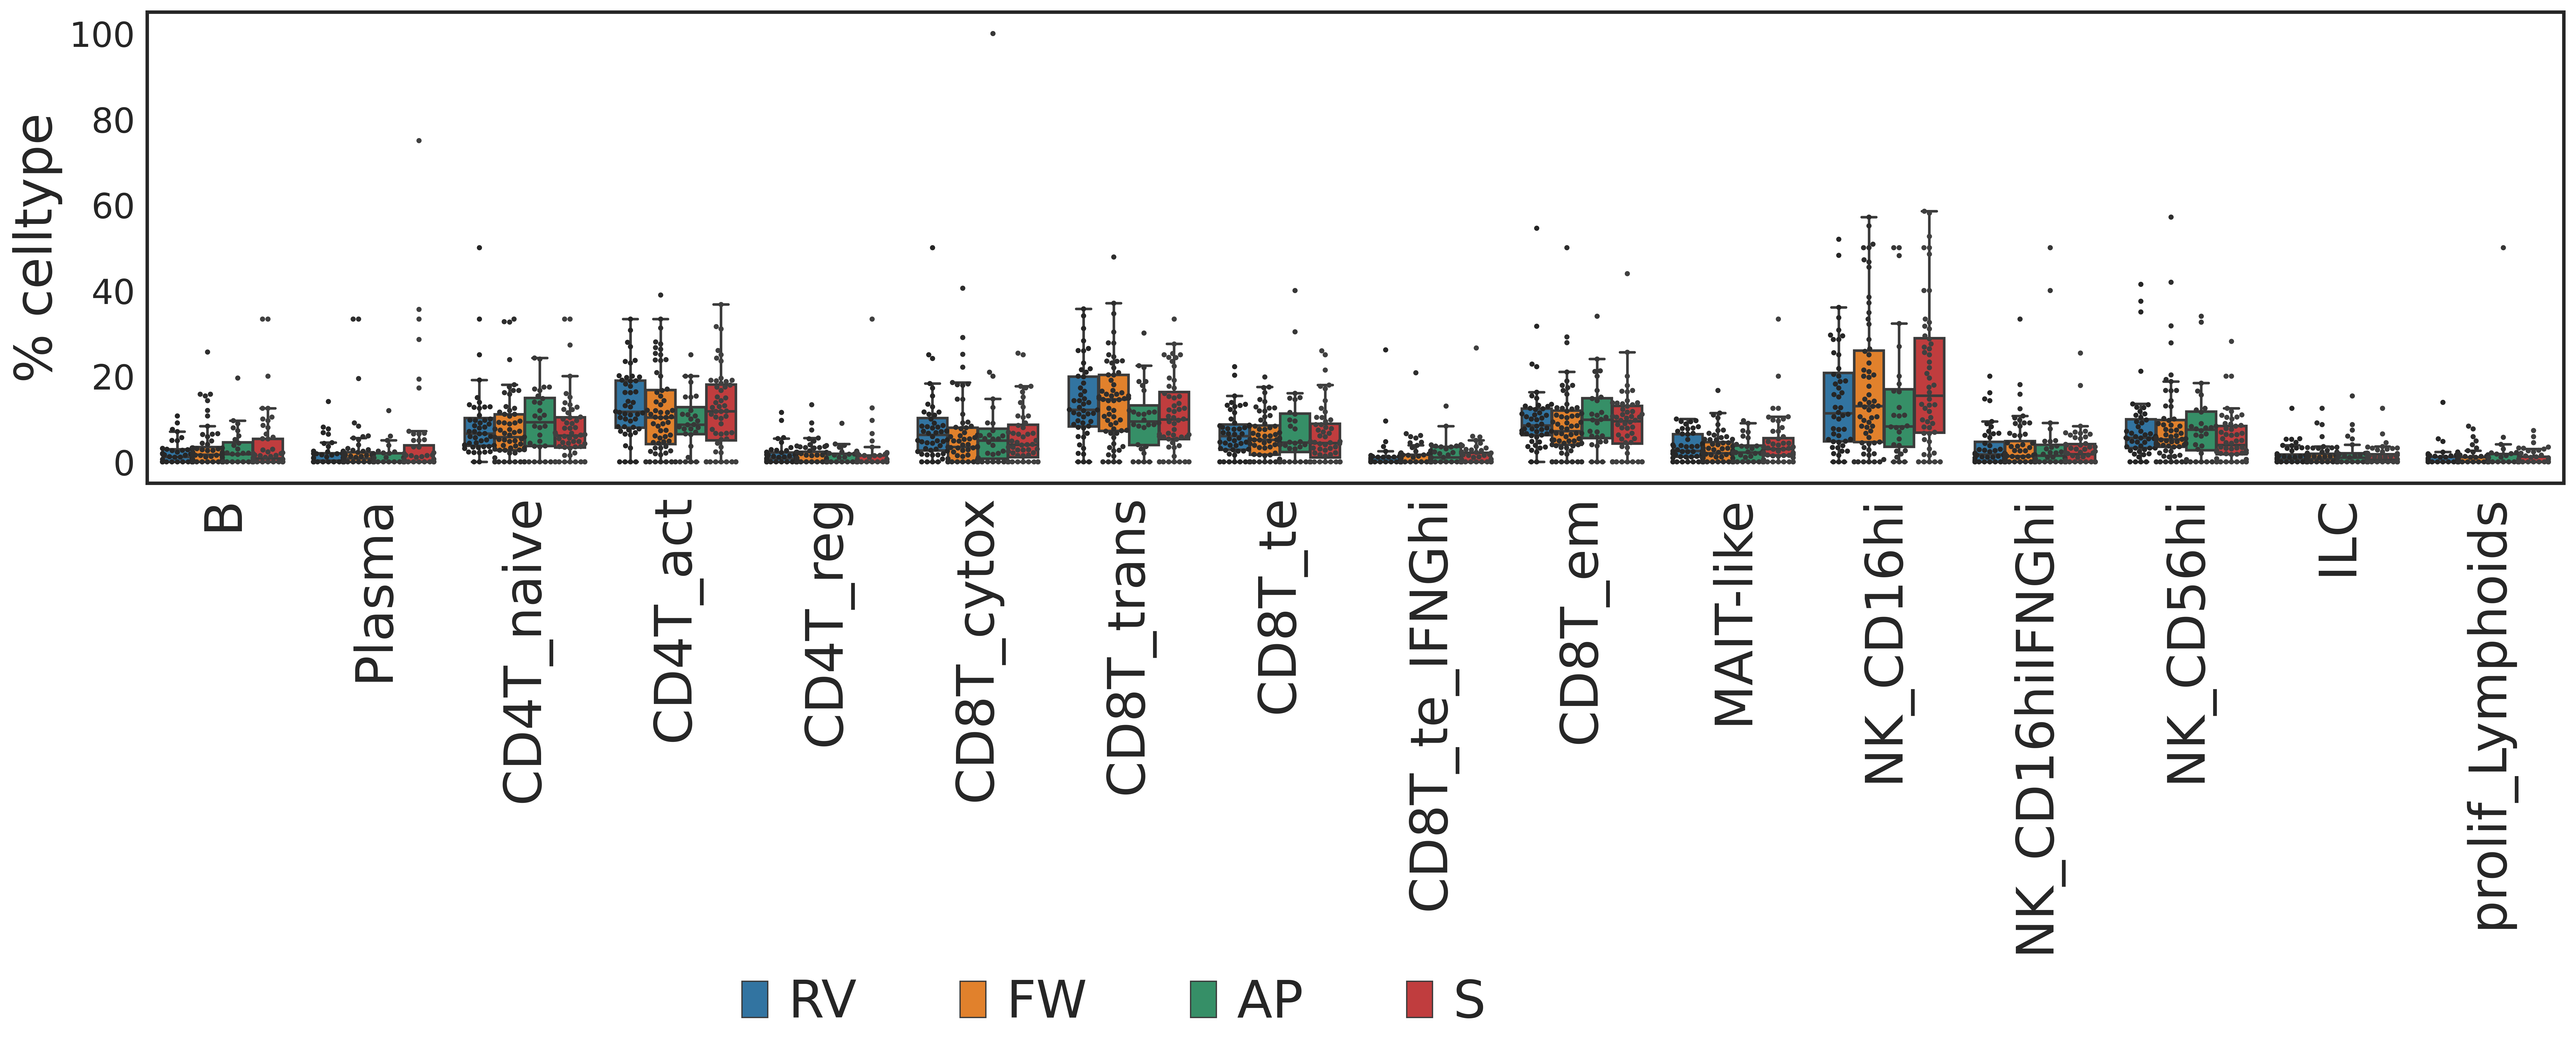

In [14]:
# plotting
# codes were extracted from plot_celltype_abundance to modify legend position, etc
final_df=df.copy()

Genes_column='Region'
y_axis_title="% celltype"

plt.figure(figsize=[25,5], dpi=500, facecolor='w', edgecolor='k')
       
sns.set_style(style='white')
flierprops = dict(markerfacecolor='0.75', markersize=3,linestyle='none')
ax=sns.swarmplot(x="variable", y="value", hue=Genes_column, data=final_df, color=".25", dodge=True, size=3)
ax=sns.boxplot(x="variable", y='value', hue=Genes_column, data=final_df, flierprops=flierprops, showfliers = False)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:len(set(final_df[Genes_column]))],
           [x.split(' ')[0] for x in labels[0:len(set(final_df[Genes_column]))]],
           bbox_to_anchor=(0.4, -1.2), loc='lower center',
           borderaxespad=0., ncol=6, fontsize='30',
          frameon=False)
            
spines = 2
ax.spines["top"].set_linewidth(spines)
ax.spines["left"].set_linewidth(spines)
ax.spines["bottom"].set_linewidth(spines)
ax.spines["right"].set_linewidth(spines)
            
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel(y_axis_title,fontsize=30)
ax.set_xlabel("",fontsize=30)
ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=20)
ax.set_title('', fontsize=40)

plt.savefig('/home/jovyan/projects/kk14_DCM-lymphoid/notebooks/final/figures/SupFig16C_abundance_Region.png', transparent=True, bbox_inches="tight")
plt.show()